In [1]:
import pandas as pd
import numpy as np
import matplotlib.style
import matplotlib.pyplot as plt
import yfinance as yf
pd.options.display.float_format = '{:.4f}'.format
plt.style.use("seaborn-v0_8")
from itertools import product

In [35]:
symbol = "EURUSD=X"
start = "2023-01-01"
end = "2024-01-01"

spread = 1.5 * 0.0001
halfspread = spread / 2
ptc = halfspread / df.price.mean()
ptc

np.float64(6.932306764204024e-05)

In [4]:
df = yf.download(symbol, start, end, interval='1h').Close.to_frame()
df.rename(columns={"Close": "price"}, inplace=True)
df

[*********************100%%**********************]  1 of 1 completed


,price
Datetime,
2023-01-02 00:00:00+00:00,1.0709
2023-01-02 01:00:00+00:00,1.0707
2023-01-02 02:00:00+00:00,1.0704
2023-01-02 03:00:00+00:00,1.0709
2023-01-02 04:00:00+00:00,1.0701
...,...
2023-12-29 18:00:00+00:00,1.1055
2023-12-29 19:00:00+00:00,1.1044
2023-12-29 20:00:00+00:00,1.1044


In [5]:
df['returns'] = np.log(df['price'].div(df['price'].shift(1)))

Window 1 | Momentum: 0.7311619604300353 | Contrarian 0.5649454387802865
Window 2 | Momentum: 0.7891492975407197 | Contrarian 0.7092317266065662
Window 3 | Momentum: 0.7841178725906708 | Contrarian 0.7997253129198155
Window 4 | Momentum: 0.8220469698335945 | Contrarian 0.8074450859137979
Window 5 | Momentum: 0.7787906723271731 | Contrarian 0.8919465577888712
Window 6 | Momentum: 0.8570643802547693 | Contrarian 0.8328138254764675
Window 7 | Momentum: 0.8582436041474408 | Contrarian 0.8569527150175953
Window 8 | Momentum: 0.8455762934694236 | Contrarian 0.8972271450427141
Window 9 | Momentum: 0.8427263671891038 | Contrarian 0.9052679621631246
Window 10 | Momentum: 0.8470477508665001 | Contrarian 0.9127173613852249
Window 11 | Momentum: 0.8445405097807132 | Contrarian 0.9200075602726455
Window 12 | Momentum: 0.9014317469114419 | Contrarian 0.8686623034605611
Window 13 | Momentum: 0.9669858441050878 | Contrarian 0.8174443737858414
Window 14 | Momentum: 0.9141270221237997 | Contrarian 0.8816

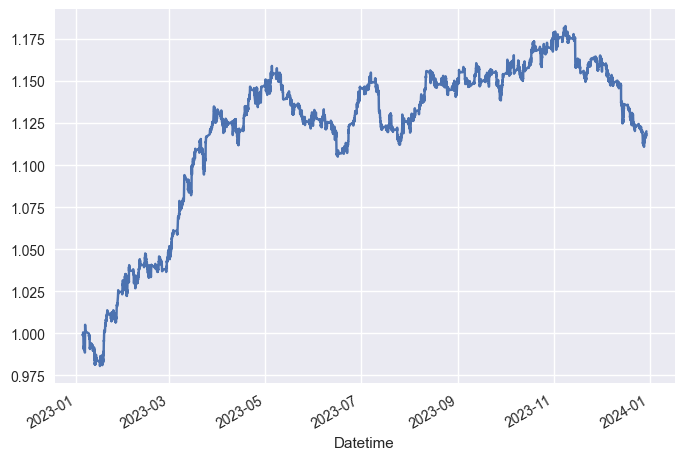

Window 75 | Momentum: 1.1063146155672297 | Contrarian 0.8257761018080966
Window 76 | Momentum: 1.0698362447525775 | Contrarian 0.853222644990995
Window 77 | Momentum: 1.0099252587938858 | Contrarian 0.9053427023662863
Window 78 | Momentum: 1.0579055669755724 | Contrarian 0.8642817388686073
Window 79 | Momentum: 1.0595428361871237 | Contrarian 0.8648626301765476
Window 80 | Momentum: 1.0628991447213034 | Contrarian 0.8568882958831503
Window 81 | Momentum: 1.0631551558858456 | Contrarian 0.8643174215334566
Window 82 | Momentum: 1.0544956626156838 | Contrarian 0.8752899519073011
Window 83 | Momentum: 1.0314986958493535 | Contrarian 0.8972889560867013
Window 84 | Momentum: 1.0209205017004312 | Contrarian 0.9101124418074681
Window 85 | Momentum: 1.0310418353616746 | Contrarian 0.9011782246138939
Window 86 | Momentum: 1.0447030933306978 | Contrarian 0.8844750083087716
Window 87 | Momentum: 1.0408364843471798 | Contrarian 0.8877607492145289
Window 88 | Momentum: 1.0641413064479202 | Contraria

,window,type,result
0,1,momentum,0.7312
1,1,contrarian,0.5649
2,2,momentum,0.7891
3,2,contrarian,0.7092
4,3,momentum,0.7841
...,...,...,...
193,97,contrarian,0.9179
194,98,momentum,1.0142
195,98,contrarian,0.9146
196,99,momentum,1.0578


In [44]:
resultsDf = pd.DataFrame(columns=['window', 'type', 'result'])

for window in range(1,100):
    df['position_momentum'] = - np.sign(df['returns'].rolling(window=window).mean())
    df['position_contrarian'] = - df['position_momentum']
    df['strategy_momentum'] = df.position_momentum.shift(1) * df.returns
    df['strategy_contrarian'] = df.position_contrarian.shift(1) * df.returns
    df['trades'] = df.position_momentum.diff().fillna(0).abs()
    df['strategy_momentum_net'] = df.strategy_momentum - df.trades*ptc
    df['cstrategy_momentum_net'] = df.strategy_momentum_net.cumsum().apply(np.exp)
    df['strategy_contrarian_net'] = df.strategy_contrarian - df.trades*ptc
    df['cstrategy_contrarian_net'] = df.strategy_contrarian_net.cumsum().apply(np.exp)
    
    result_momentum = df['cstrategy_momentum_net'].iloc[-1]
    result_contrarian = df['cstrategy_contrarian_net'].iloc[-1]

    resultDictMomentum = {'window': window, 'type': 'momentum', 'result': result_momentum}
    resultDictContrarian = {'window': window, 'type': 'contrarian', 'result': result_contrarian}
    resultsDf.loc[len(resultsDf)] = resultDictMomentum
    resultsDf.loc[len(resultsDf)] = resultDictContrarian
    print('Window {} | Momentum: {} | Contrarian {}'.format(window, result_momentum, result_contrarian))
    
    if window == 74:
        df.cstrategy_momentum_net.plot()
        plt.show()

resultsDf

<Axes: >

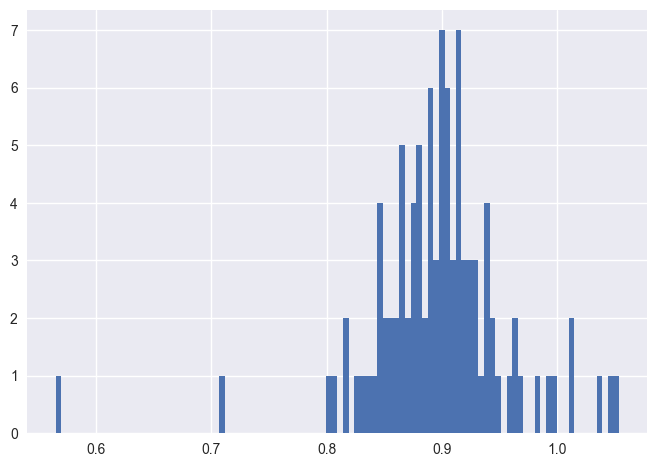

In [40]:
resultsDf['result'].where(resultsDf['type'] == 'momentum')
resultsDf['result'].where(resultsDf['type'] == 'contrarian').hist(bins=100)

In [41]:
resultsDf['result'].where(resultsDf['type'] == 'momentum').describe()

count   99.0000
mean     0.9756
std      0.0857
min      0.7312
25%      0.9099
50%      1.0009
75%      1.0415
max      1.1201
Name: result, dtype: float64

<Axes: >

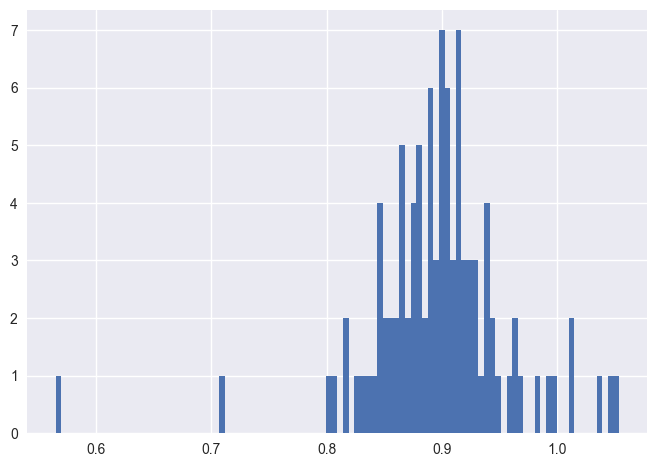

In [42]:
resultsDf['result'].where(resultsDf['type'] == 'contrarian').hist(bins=100)

In [43]:
resultsDf['result'].where(resultsDf['type'] == 'contrarian').describe()

count   99.0000
mean     0.8970
std      0.0626
min      0.5649
25%      0.8678
50%      0.8973
75%      0.9234
max      1.0536
Name: result, dtype: float64